Richman先生のチュートリアルをBybitでやってみる。
https://github.com/richmanbtc/mlbot_tutorial/blob/master/work/tutorial.ipynb


準備：
必要なライブラリをpipでインストールする。

単純にPipでインストールできないTALIBはこの辺り参考にインストールしておく。
https://qiita.com/ConnieWild/items/cb50f36425a683c914d2

In [4]:
import math

import ccxt
# from crypto_data_fetcher.gmo import GmoFetcher 今回はBybitを利用。
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp
import seaborn as sns
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit

In [8]:
#　データの準備

import rbot

bb = rbot.DummyBb()
bb.restore()
df = rbot.array_to_df(bb.ohlcv(0, 0, 60 *15))
df.columns=["op", "hi", "lo", "cl", "volume"]

In [9]:
df

,op,hi,lo,cl,volume
timestamp,,,,,
2022-03-27 00:00:00+00:00,44530.0,44575.0,44495.5,44551.0,4206185.0
2022-03-27 00:15:00+00:00,44550.5,44569.5,44519.0,44533.0,2980648.0
2022-03-27 00:30:00+00:00,44533.5,44700.0,44510.5,44646.5,12832280.0
2022-03-27 00:45:00+00:00,44646.0,44730.0,44642.0,44713.5,10455447.0
2022-03-27 01:00:00+00:00,44713.5,44761.5,44638.0,44675.0,10148246.0
...,...,...,...,...,...
2022-07-04 22:45:00+00:00,19990.0,20230.0,19965.0,20130.0,43093646.0
2022-07-04 23:00:00+00:00,20129.5,20193.0,20081.0,20105.5,13472607.0
2022-07-04 23:15:00+00:00,20105.5,20280.0,20105.5,20244.0,24856396.0


# maker手数料カラムを追加

In [10]:
df['fee'] = 0.001

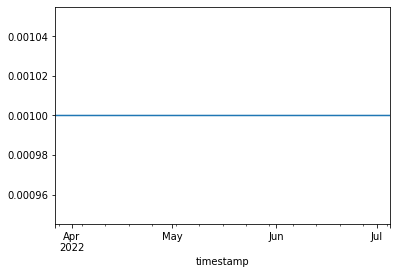

In [11]:
df['fee'].plot()
plt.show()

In [12]:
df

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2022-03-27 00:00:00+00:00,44530.0,44575.0,44495.5,44551.0,4206185.0,0.001
2022-03-27 00:15:00+00:00,44550.5,44569.5,44519.0,44533.0,2980648.0,0.001
2022-03-27 00:30:00+00:00,44533.5,44700.0,44510.5,44646.5,12832280.0,0.001
2022-03-27 00:45:00+00:00,44646.0,44730.0,44642.0,44713.5,10455447.0,0.001
2022-03-27 01:00:00+00:00,44713.5,44761.5,44638.0,44675.0,10148246.0,0.001
...,...,...,...,...,...,...
2022-07-04 22:45:00+00:00,19990.0,20230.0,19965.0,20130.0,43093646.0,0.001
2022-07-04 23:00:00+00:00,20129.5,20193.0,20081.0,20105.5,13472607.0,0.001
2022-07-04 23:15:00+00:00,20105.5,20280.0,20105.5,20244.0,24856396.0,0.001


# 特徴量エンジニアリング

In [13]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

In [14]:
df = df.dropna()
df = calc_features(df)
df

,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2022-03-27 00:00:00+00:00,44530.0,44575.0,44495.5,44551.0,4206185.0,0.001,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-27 00:15:00+00:00,44550.5,44569.5,44519.0,44533.0,2980648.0,0.001,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-27 00:30:00+00:00,44533.5,44700.0,44510.5,44646.5,12832280.0,0.001,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-27 00:45:00+00:00,44646.0,44730.0,44642.0,44713.5,10455447.0,0.001,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-03-27 01:00:00+00:00,44713.5,44761.5,44638.0,44675.0,10148246.0,0.001,64.697929,-75.95,-216.597929,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,70.323965
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-04 22:45:00+00:00,19990.0,20230.0,19965.0,20130.0,43093646.0,0.001,54.891733,-134.40,-323.691733,-154.718216,...,0.835916,0.202981,0,0.305819,0.869896,-148.257143,87.347019,-428.814286,21.581319,94.645866
2022-07-04 23:00:00+00:00,20129.5,20193.0,20081.0,20105.5,13472607.0,0.001,76.002804,-138.00,-352.002804,-165.514080,...,0.682661,-0.033994,0,0.135045,0.894266,-68.571429,87.813558,-409.071429,26.192308,107.001402
2022-07-04 23:15:00+00:00,20105.5,20280.0,20105.5,20244.0,24856396.0,0.001,110.756541,-114.75,-340.256541,-178.291932,...,0.556183,-0.194367,1,-0.079422,0.919895,-119.428571,88.354386,-571.928571,34.807692,112.753270


# 学習に使う特徴量の定義

In [15]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

print(features)

['ADX', 'ADXR', 'APO', 'AROONOSC', 'AROON_aroondown', 'AROON_aroonup', 'BBANDS_lowerband', 'BBANDS_middleband', 'BBANDS_upperband', 'BETA', 'CCI', 'DEMA', 'DX', 'EMA', 'HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR_inphase', 'HT_PHASOR_quadrature', 'HT_TRENDLINE', 'HT_TRENDMODE', 'KAMA', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'MA', 'MACD_macd', 'MACD_macdhist', 'MACD_macdsignal', 'MFI', 'MIDPOINT', 'MOM', 'RSI', 'STDDEV', 'STOCHF_fastk', 'STOCH_slowd', 'STOCH_slowk', 'T3', 'TEMA', 'TRIMA', 'ULTOSC', 'WILLR', 'WMA']


#目的変数の計算

約定確率を可視化。時期によって約定確率が大きく変わると良くない。


/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 32004 (\N{CJK UNIFIED IDEOGRAPH-7D04}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 23450 (\N{CJK UNIFIED IDEOGRAPH-5B9A}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 30906 (\N{CJK UNIFIED IDEOGRAPH-78BA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 29575 (\N{CJK UNIFIED IDEOGRAPH-7387}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/op

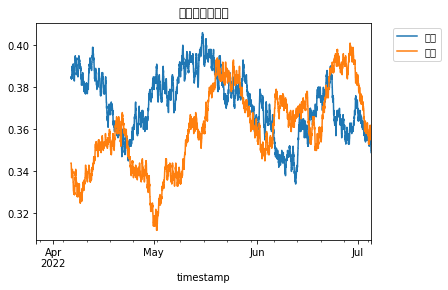

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12456 (\N{KATAKANA LETTER E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12464 (\N{KATAKANA LETTER GU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12472 (\N{KATAKANA LETTER ZI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12483 (\N{KATAKANA LETTER SMALL TU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12488 (\N{KATAKANA LETTER TO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/si

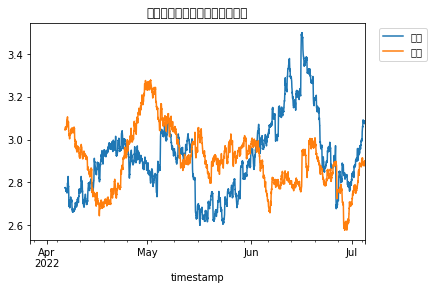

/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 20998 (\N{CJK UNIFIED IDEOGRAPH-5206}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 24067 (\N{CJK UNIFIED IDEOGRAPH-5E03}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


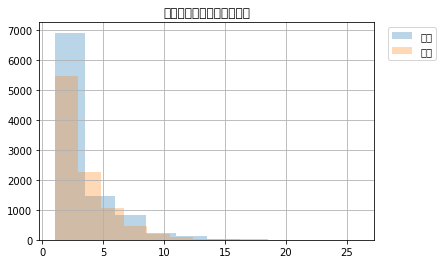

/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

毎時刻、この執行方法でトレードした場合の累積リターン


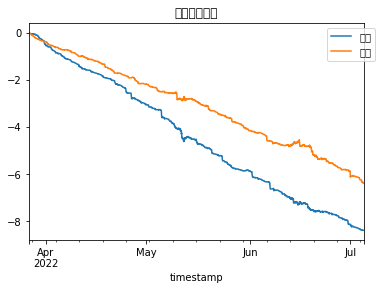

In [19]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

# df = pd.read_pickle('df_features.pkl')

# 呼び値 (取引所、取引ペアごとに異なるので、適切に設定してください)
pips = 1

# ATRで指値距離を計算します
limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

# 終値から両側にlimit_price_distだけ離れたところに、買い指値と売り指値を出します
df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

# Force Entry Priceの計算
df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力と出力をマイナスにすれば売りに使えます
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1 # エントリーしてからエグジットを始めるまでの待ち時間 (1以上である必要がある)
fee = df['fee'] # maker手数料

# 指値が約定したかどうか (0, 1)
df['buy_executed'] = ((df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()).astype('float64')
df['sell_executed'] = ((df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()).astype('float64')

# yを計算
df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用する取引コストを計算
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot(label='買い')
df['sell_executed'].rolling(1000).mean().plot(label='売り')
plt.title('約定確率の推移')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot(label='買い')
df['sell_fet'].rolling(1000).mean().plot(label='売り')
plt.title('エグジットまでの平均時間推移')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

df['buy_fet'].hist(alpha=0.3, label='買い')
df['sell_fet'].hist(alpha=0.3, label='売り')
plt.title('エグジットまでの時間分布')
plt.legend(bbox_to_anchor=(1.2, 1))
plt.show()

print('毎時刻、この執行方法でトレードした場合の累積リターン')
df['y_buy'].cumsum().plot(label='買い')
df['y_sell'].cumsum().plot(label='売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

df.to_pickle('df_y.pkl')


# モデルの学習とOOS予測値計算

毎時刻、y_predがプラスのときだけトレードした場合の累積リターン


/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 32047 (\N{CJK UNIFIED IDEOGRAPH-7D2F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 31309 (\N{CJK UNIFIED IDEOGRAPH-7A4D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12522 (\N{KATAKANA LETTER RI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12479 (\N{KATAKANA LETTER TA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)

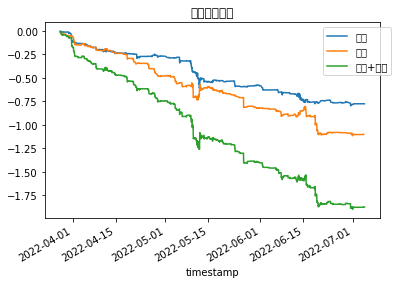

In [20]:
df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# モデル (コメントアウトで他モデルも試してみてください)
# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)

# アンサンブル (コメントアウトを外して性能を比較してみてください)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 本番用モデルの学習 (このチュートリアルでは使わない)
# 実稼働する用のモデルはデータ全体で学習させると良い
model.fit(df[features], df['y_buy'])
joblib.dump(model, 'model_y_buy.xz', compress=True) 
model.fit(df[features], df['y_sell'])
joblib.dump(model, 'model_y_sell.xz', compress=True)

# 通常のCV
cv_indicies = list(KFold().split(df))
# ウォークフォワード法
# cv_indicies = list(TimeSeriesSplit().split(df))

# OOS予測値を計算
def my_cross_val_predict(estimator, X, y=None, cv=None):
    y_pred = y.copy()
    y_pred[:] = np.nan
    for train_idx, val_idx in cv:
        estimator.fit(X[train_idx], y[train_idx])
        y_pred[val_idx] = estimator.predict(X[val_idx])
    return y_pred

df['y_pred_buy'] = my_cross_val_predict(model, df[features].values, df['y_buy'].values, cv=cv_indicies)
df['y_pred_sell'] = my_cross_val_predict(model, df[features].values, df['y_sell'].values, cv=cv_indicies)

# 予測値が無い(nan)行をドロップ
df = df.dropna()

print('毎時刻、y_predがプラスのときだけトレードした場合の累積リターン')
df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot(label='買い')
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot(label='売り')
(df['y_buy'] * (df['y_pred_buy'] > 0) + df['y_sell'] * (df['y_pred_sell'] > 0)).cumsum().plot(label='買い+売り')
plt.title('累積リターン')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()